# Figure 5

In [1]:
%load_ext watermark
%watermark -a "Etienne Ackermann," -n -t -v -p nelpy,numpy,scipy,pandas,matplotlib

C:\Users\etien\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.


Etienne Ackermann, Thu Feb 07 2019 10:54:33 

CPython 3.6.4
IPython 6.2.1

nelpy 0.2.0
numpy 1.14.2
scipy 1.0.0
pandas 0.23.4
matplotlib 2.2.2


In [2]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import tabulate

import scipy.stats as stats

from IPython.display import HTML, display, clear_output
from mpl_toolkits.axes_grid1 import make_axes_locatable

import nelpy as nel
import nelpy.plotting as npl

# Set default figure aesthetics
npl.setup(font_scale=1.0)

%matplotlib inline

warnings.filterwarnings("ignore")

In [3]:
datadirs = ['data/']

fileroot = next( (dir for dir in datadirs if os.path.isdir(dir)), None)

if fileroot is None:
    raise FileNotFoundError('datadir not found')

load_from_nel = True

if load_from_nel:
    jar = nel.load_pkl(fileroot + 'fig1.nel')
    exp_data = jar.exp_data
    aux_data = jar.aux_data
    del jar

jar = nel.load_pkl(fileroot + 'sessions_segments.nel')
sessions = jar.sessions
segments = jar.segments

jar = nel.load_pkl(fileroot + 'score_results.nel')
score_results = jar.score_results

In [4]:
session = '16-40-19'; segment = 'short' # 'long' or 'short'

In [5]:
def plot_all_PBEs(bst, spiketrainarray, tuningcurve, tc_placecells, idx=None, title_str=None):
    if idx is not None:
        bst = bst[idx]
    st = spiketrainarray
    tc = tuningcurve
    tc_placecells = tc_placecells

    no = tc_placecells.get_peak_firing_order_ids()
    st.reorder_units_by_ids(no, inplace=True)

    st_cut = st[bst.support]
    st_cut._support = bst.support # hacky fix so that we can plot events out of order
    st_cut = nel.utils.collapse_time(st_cut)

    # decode neural activity
    posterior, bdries, mode_pth, mean_pth = nel.decoding.decode1D(bst=bst, ratemap=tc, xmax=310)

    with npl.FigureManager(show=True, figsize=(0.08*bst.n_bins,2)) as (fig, ax):
        npl.utils.skip_if_no_output(fig)

        pixel_width = 0.5

        npl.imagesc(x=np.arange(bst.n_bins), y=np.arange(311), data=posterior, cmap=plt.cm.Spectral_r, ax=ax)
#         npl.utils.yticks_interval(310)
        npl.utils.no_yticks(ax)
        # plt.imshow(posterior, cmap=plt.cm.Spectral_r, interpolation='none', aspect='auto')
        ax.vlines(np.arange(bst.lengths.sum())-pixel_width, *ax.get_ylim(), lw=1, linestyle=':', color='0.8')
        ax.vlines(np.cumsum(bst.lengths)-pixel_width, *ax.get_ylim(), lw=1)

        ax.set_xlim(-pixel_width, bst.lengths.sum()-pixel_width)

        event_centers = np.insert(np.cumsum(bst.lengths),0,0)
        event_centers = event_centers[:-1] + bst.lengths/2 - 0.5

        ax.set_xticks(event_centers);
        if idx is not None:
            ax.set_xticklabels(idx);
        else:
            ax.set_xticklabels(np.arange(bst.n_epochs));

        npl.utils.no_xticks(ax)
        ax.set_ylim(0,250)

        divider = make_axes_locatable(ax)
        axRaster = divider.append_axes("top", size=0.6, pad=0)

        npl.rasterplot(st_cut, vertstack=True, ax=axRaster, lh=1.25)
        axRaster.set_xlim(st_cut.support.time.squeeze())
        bin_edges = np.linspace(st_cut.support.time[0,0],st_cut.support.time[0,1], bst.n_bins+1)
    #     axRaster.vlines(bin_edges, *ax.get_ylim(), lw=1, linestyle=':', color='0.2')
        axRaster.vlines(bin_edges[np.cumsum(bst.lengths)], *ax.get_ylim(), lw=1, color='0.2')
        npl.utils.no_xticks(axRaster)
        npl.utils.no_xticklabels(axRaster)
        npl.utils.no_yticklabels(axRaster)
        npl.utils.no_yticks(axRaster)
        ax.set_ylabel('position [cm]')
        ax.set_xlabel('time bins (20 ms)')
        if title_str:
            fig.suptitle(title_str)
        npl.utils.clear_left_right(axRaster)
        npl.utils.clear_top_bottom(axRaster)


In [6]:
# nn = 126
# bst = aux_data[session][segment]['PBEs'][nn]

# scores, shuffled_scores, percentiles = nel.analysis.replay.score_Davidson_final_bst_fast(bst=bst,
#                                                                                          tuningcurve=tc,
#                                                                                          w=w,
#                                                                                          n_shuffles=n_shuffles,
#                                                                                          n_samples=n_samples)
# print(scores)
# print(percentiles)

In [7]:
pooled_percentiles_hmm = [] 
pooled_percentiles_bayes = [] 
for session, segment in zip(sessions, segments):
    pooled_percentiles_hmm.extend(score_results[session][segment]['scores_hmm_percentile'].tolist())
    pooled_percentiles_bayes.extend(score_results[session][segment]['scores_bayes_percentile'].tolist())
    
pooled_percentiles_hmm = np.array(sorted(pooled_percentiles_hmm))
pooled_percentiles_bayes = np.array(sorted(pooled_percentiles_bayes))

In [8]:
# obtain thresholds from pooled data
threshold_bayes = 99

n_scores = len(pooled_percentiles_hmm)
x = 100 - np.linspace(0,100, n_scores)

cum_perc_sig = bx = 100 - [next(ii for (ii, item) in enumerate((pooled_percentiles_bayes<threshold_bayes).tolist()) if item is False)][0]/n_scores*100
threshold_hmm = float(pooled_percentiles_hmm[np.argwhere(x < cum_perc_sig)[0]])

n_events = 0
n_HS_BS = 0
n_HS_BNS = 0
n_HNS_BS = 0
n_HNS_BNS = 0
    
for session, segment in zip(sessions, segments):
    
    n_events += len(score_results[session][segment]['scores_hmm_percentile'])
    idx_all = set(range(n_events))
    BS = set(np.where(score_results[session][segment]['scores_bayes_percentile']>=threshold_bayes)[0])
    BNS = set(np.where(score_results[session][segment]['scores_bayes_percentile']<threshold_bayes)[0])
    HS = set(np.where(score_results[session][segment]['scores_hmm_percentile']>=threshold_hmm)[0])
    HNS = set(np.where(score_results[session][segment]['scores_hmm_percentile']<threshold_hmm)[0])
    BS_HS = np.array(list(BS.intersection(HS))).astype(int)
    BS_HNS = np.array(list(BS.intersection(HNS))).astype(int)
    BNS_HS = np.array(list(BNS.intersection(HS))).astype(int)
    BNS_HNS = np.array(list(BNS.intersection(HNS))).astype(int)

    n_HS_BS += len(BS_HS)
    n_HS_BNS += len(BNS_HS)
    n_HNS_BS += len(BS_HNS)
    n_HNS_BNS += len(BNS_HNS)

conf_mat = np.array([[n_HS_BNS, n_HS_BS],[n_HNS_BNS, n_HNS_BS]])

table = [["HMM +", n_HS_BS, n_HS_BNS, n_HS_BS+n_HS_BNS],
         ["HMM -", n_HNS_BS, n_HNS_BNS, n_HNS_BS + n_HNS_BNS],
        ["", n_HS_BS + n_HNS_BS, n_HS_BNS + n_HNS_BNS, ""]]
display(HTML(tabulate.tabulate(table, headers=["N={}".format(n_events),"Bayes +", "Bayes -", ""], tablefmt='html')))

oddsratio, p_value = stats.fisher_exact(np.array([[n_HS_BNS, n_HS_BS],[n_HNS_BNS, n_HNS_BS]]), alternative='two-sided')
print("Fisher's exact test, two-tailed p value:", p_value)

print('{:1.1f}% event agreement'.format((n_HS_BS + n_HNS_BNS) / n_events*100))


N=1883,Bayes +,Bayes -,
HMM +,696,368,1064
HMM -,368,451,819
,1064,819,


Fisher's exact test, two-tailed p value: 6.183940695994674e-19
60.9% event agreement


# Look at all classification types

In [9]:
session, segment = '16-40-19', 'short'

bst = aux_data[session][segment]['PBEs_noIN']
st = aux_data[session][segment]['st_placecells_noIN']
tc = aux_data[session][segment]['tc_noIN']
tc_placecells = aux_data[session][segment]['tc_placecells_noIN']
bst.n_epochs

n_events = len(score_results[session][segment]['scores_hmm_percentile'])
idx_all = set(range(n_events))
BS = set(np.where(score_results[session][segment]['scores_bayes_percentile']>=threshold_bayes)[0])
BNS = set(np.where(score_results[session][segment]['scores_bayes_percentile']<threshold_bayes)[0])
HS = set(np.where(score_results[session][segment]['scores_hmm_percentile']>=threshold_hmm)[0])
HNS = set(np.where(score_results[session][segment]['scores_hmm_percentile']<threshold_hmm)[0])
BS_HS = np.array(list(BS.intersection(HS))).astype(int)
BS_HNS = np.array(list(BS.intersection(HNS))).astype(int)
BNS_HS = np.array(list(BNS.intersection(HS))).astype(int)
BNS_HNS = np.array(list(BNS.intersection(HNS))).astype(int)

n_HS_BS = len(BS_HS)
n_HS_BNS = len(BNS_HS)
n_HNS_BS = len(BS_HNS)
n_HNS_BNS = len(BNS_HNS)

conf_mat = np.array([[n_HS_BNS, n_HS_BS],[n_HNS_BNS, n_HNS_BS]])

table = [["HMM +", n_HS_BS, n_HS_BNS, n_HS_BS+n_HS_BNS],
         ["HMM -", n_HNS_BS, n_HNS_BNS, n_HNS_BS + n_HNS_BNS],
        ["", n_HS_BS + n_HNS_BS, n_HS_BNS + n_HNS_BNS, ""]]
display(HTML(tabulate.tabulate(table, headers=["N={}".format(n_events),"Bayes +", "Bayes -", ""], tablefmt='html')))

oddsratio, p_value = stats.fisher_exact(np.array([[n_HS_BNS, n_HS_BS],[n_HNS_BNS, n_HNS_BS]]), alternative='two-sided')
print("Fisher's exact test, two-tailed p value:", p_value)

negative = np.argwhere(score_results[session][segment]['manual_scores'] == 1).squeeze()
positive = np.argwhere(score_results[session][segment]['manual_scores'] == 5).squeeze()

TPh = np.count_nonzero([h in positive for h in HS]) / len(positive)
TNh = np.count_nonzero([h in negative for h in HNS]) / len(negative)
FPh = np.count_nonzero([h in negative for h in HS]) / len(negative)
FNh = np.count_nonzero([h in positive for h in HNS]) / len(positive)

TPb = np.count_nonzero([h in positive for h in BS]) / len(positive)
TNb = np.count_nonzero([h in negative for h in BNS]) / len(negative)
FPb = np.count_nonzero([h in negative for h in BS]) / len(negative)
FNb = np.count_nonzero([h in positive for h in BNS]) / len(positive)

FNhidx = [h for h in HNS if h in positive]
FNbidx = [b for b in BNS if b in positive]

TNhidx = [h for h in HNS if h in negative]
TNbidx = [b for b in BNS if b in negative]

TPhidx = [h for h in HS if h in positive]
TPbidx = [b for b in BS if b in positive]

FPhidx = [h for h in HS if h in negative]
FPbidx = [b for b in BS if b in negative]

N=277,Bayes +,Bayes -,
HMM +,160,39,199
HMM -,48,30,78
,208,69,


Fisher's exact test, two-tailed p value: 0.0018412256922682234


In [10]:
# Examples
#
# (TPh,TPb)  (TPh,FNb) | (FPh,FPb)  (FPh,TNb)
# (TPh,TPb)  (TPh,FNb) | (FPh,FPb)  (FPh,TNb)
# -------------------------------------------
# (FNh,TPb)  (FNh,FNb) | (TNh,FPb)  (TNh,TNb)
# (FNh,TPb)  (FNh,FNb) | (TNh,FPb)  (TNh,TNb)

HMM true positive | Bayes true positive


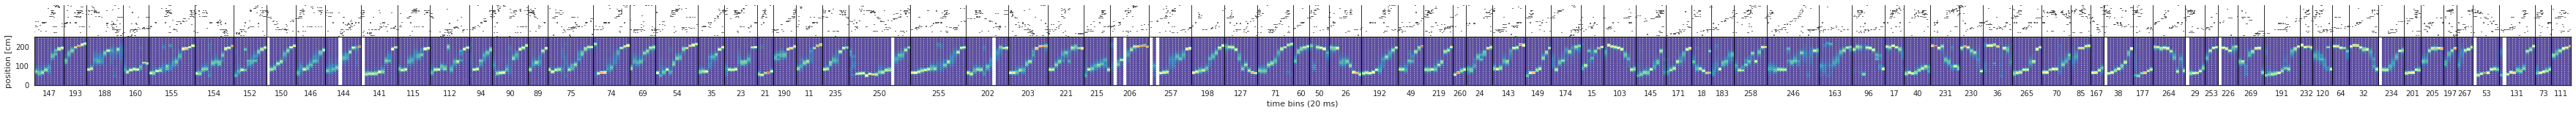

HMM true positive | Bayes false negative


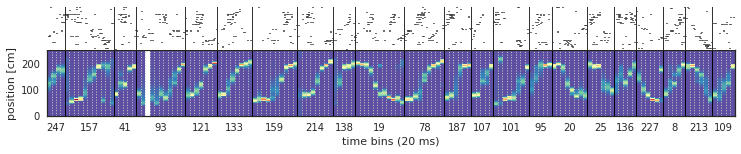

HMM false negative | Bayes true positive


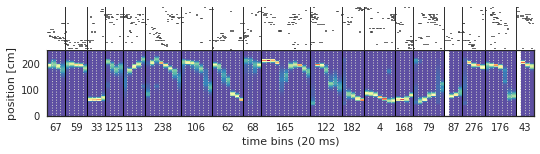

HMM false negative | Bayes false negative


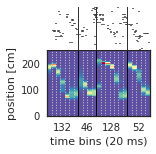

HMM false positive | Bayes false positive


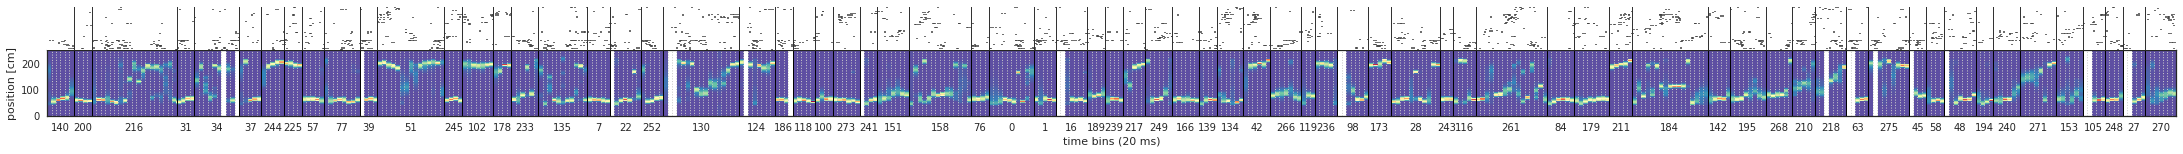

HMM false positive | Bayes true negative


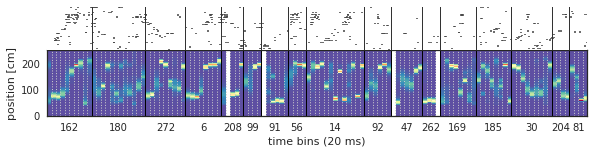

HMM true negative | Bayes false positive


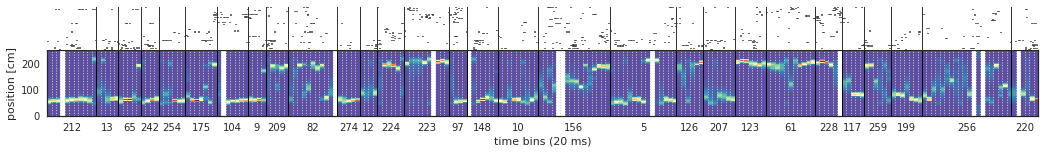

HMM true negative | Bayes true negative


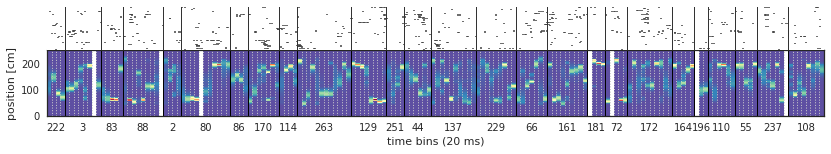

In [11]:
# (1,1) (2,1)
print('HMM true positive | Bayes true positive')
TPhTPb = sorted(list(set(TPhidx).intersection(TPbidx)))
b_order = np.argsort(score_results[session][segment]['scores_bayes_percentile'][TPhTPb])[::-1]
h_order = np.argsort(score_results[session][segment]['scores_hmm_percentile'][TPhTPb])[::-1]
new_order = h_order
plot_all_PBEs(bst, st, tc, tc_placecells, idx=(np.array(TPhTPb)[new_order]).tolist())

# (1,2) (2,2)
print('HMM true positive | Bayes false negative')
TPhFNb = sorted(list(set(TPhidx).intersection(FNbidx)))
b_order = np.argsort(score_results[session][segment]['scores_bayes_percentile'][TPhFNb])[::-1]
h_order = np.argsort(score_results[session][segment]['scores_hmm_percentile'][TPhFNb])[::-1]
new_order = h_order
plot_all_PBEs(bst, st, tc, tc_placecells, idx=(np.array(TPhFNb)[new_order]).tolist())

# (3,1) (4,1)
print('HMM false negative | Bayes true positive')
FNhTPb = sorted(list(set(FNhidx).intersection(TPbidx)))
b_order = np.argsort(score_results[session][segment]['scores_bayes_percentile'][FNhTPb])[::-1]
h_order = np.argsort(score_results[session][segment]['scores_hmm_percentile'][FNhTPb])[::-1]
new_order = h_order
plot_all_PBEs(bst, st, tc, tc_placecells, idx=(np.array(FNhTPb)[new_order]).tolist())

# (3,2) (4,2)
print('HMM false negative | Bayes false negative')
FNhFNb = sorted(list(set(FNhidx).intersection(FNbidx)))
b_order = np.argsort(score_results[session][segment]['scores_bayes_percentile'][FNhFNb])
h_order = np.argsort(score_results[session][segment]['scores_hmm_percentile'][FNhFNb])
new_order = h_order
plot_all_PBEs(bst, st, tc, tc_placecells, idx=(np.array(FNhFNb)[new_order]).tolist())

# (1,3) (2,3)
print('HMM false positive | Bayes false positive')
FPhFPb = sorted(list(set(FPhidx).intersection(FPbidx)))
b_order = np.argsort(score_results[session][segment]['scores_bayes_percentile'][FPhFPb])[::-1]
h_order = np.argsort(score_results[session][segment]['scores_hmm_percentile'][FPhFPb])[::-1]
new_order = h_order
plot_all_PBEs(bst, st, tc, tc_placecells, idx=(np.array(FPhFPb)[new_order]).tolist())

# (1,4) (2,4)
print('HMM false positive | Bayes true negative')
FPhTNb = sorted(list(set(FPhidx).intersection(TNbidx)))
b_order = np.argsort(score_results[session][segment]['scores_bayes_percentile'][FPhTNb])[::-1]
h_order = np.argsort(score_results[session][segment]['scores_hmm_percentile'][FPhTNb])[::-1]
new_order = h_order
plot_all_PBEs(bst, st, tc, tc_placecells, idx=(np.array(FPhTNb)[new_order]).tolist())

# (3,3) (4,3)
print('HMM true negative | Bayes false positive')
TNhFPb = sorted(list(set(TNhidx).intersection(FPbidx)))
b_order = np.argsort(score_results[session][segment]['scores_bayes_percentile'][TNhFPb])[::-1]
h_order = np.argsort(score_results[session][segment]['scores_hmm_percentile'][TNhFPb])[::-1]
new_order = h_order
plot_all_PBEs(bst, st, tc, tc_placecells, idx=(np.array(TNhFPb)[new_order]).tolist())

# (3,4) (4,4)
print('HMM true negative | Bayes true negative')
TNhTNb = sorted(list(set(TNhidx).intersection(TNbidx)))
b_order = np.argsort(score_results[session][segment]['scores_bayes_percentile'][TNhTNb])[::-1]
h_order = np.argsort(score_results[session][segment]['scores_hmm_percentile'][TNhTNb])[::-1]
new_order = h_order
plot_all_PBEs(bst, st, tc, tc_placecells, idx=(np.array(TNhTNb)[new_order]).tolist())